THE library , usage and clear instructions can be found at https://georgebv.github.io/pyextremes/quickstart/

In [29]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

In [30]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import plot_mean_residual_life
from closest_grid_cell import select_nearest_grid_cell
from pyextremes import plot_parameter_stability
from pyextremes import plot_return_value_stability

Threshold selection : based on Mean Residual Life (https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/)

#Estimation of Mean Residual life

In [31]:
data_hr_precip= xr.open_dataset(f'{config.TARGET_DIR}/RhiresD_1971_2023.nc')
data_hr_precip= data_hr_precip.sel(time=slice('1981-01-01', '2010-12-31'))

In [32]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [33]:
data_hr_precip_locarno = select_nearest_grid_cell(data_hr_precip, target_lat, target_lon, 'RhiresD')
    
precip_series_hr = data_hr_precip_locarno['data']
lat_idx = data_hr_precip_locarno['lat_idx']
lon_idx = data_hr_precip_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14


In [34]:
precip_series_hr_pd= precip_series_hr.to_pandas()

Ways of chosing a threshold : MRL (1)

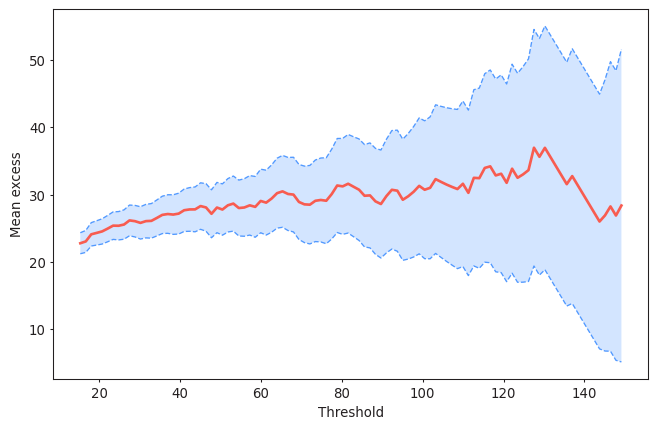

In [35]:
plot_mean_residual_life(precip_series_hr_pd)
plt.show() #MRL is the least useful as it is visually subjective

Method II : Parametric Stability 

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

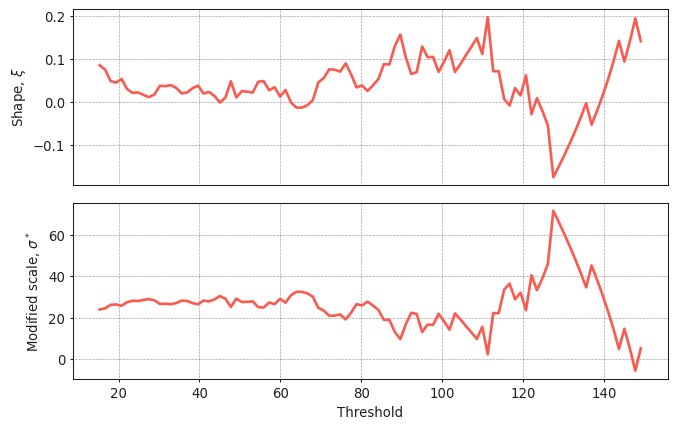

In [36]:
plot_parameter_stability(precip_series_hr_pd) #Stabilises around 60 mm as the threshold and the higher variance with increasing threshold 

Method III : extension of Method II : return value stability 

Return value stability for 10-year return level:
Return value stability for 50-year return level:
Return value stability for 100-year return level:


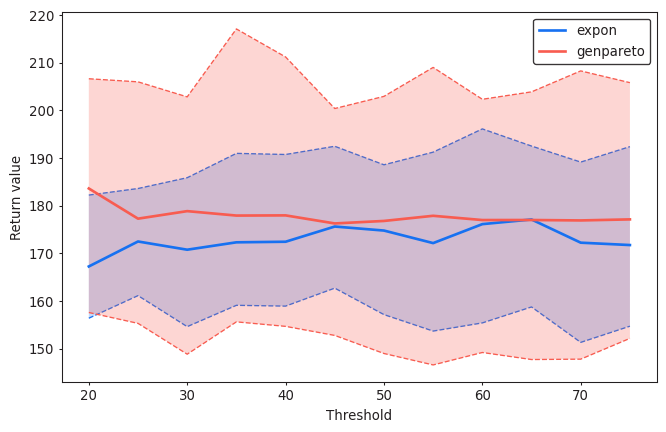

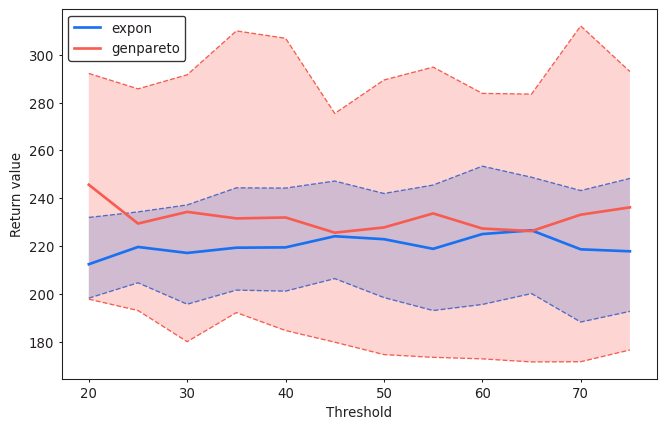

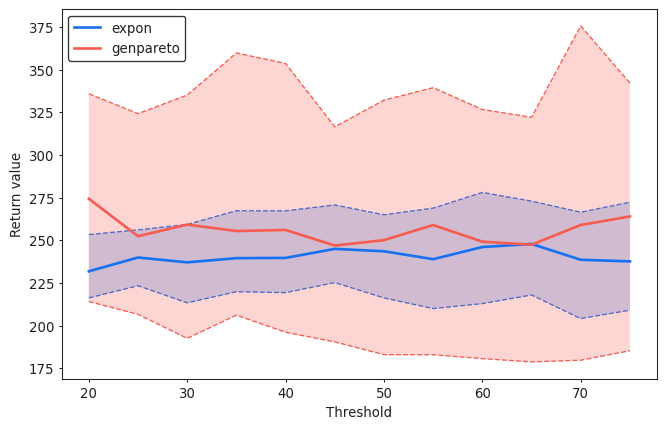

In [37]:
for i, period in enumerate([10,50,100]):
    print(f"Return value stability for {period}-year return level:")
    plot_return_value_stability(precip_series_hr_pd, 
                                return_period=period, 
                                thresholds= np.arange(20,80,5),
                                alpha=0.95,)
    

#Return value : the amount to be exceeded every 

Threshold value of around 50 mm/day was selected for precip. Based on methods 1 and II!

In [38]:
from pyextremes import get_extremes, get_return_periods, EVA

In [39]:
gpd_precip_bm_model = EVA(precip_series_hr_pd)
extremes_pr= gpd_precip_bm_model.get_extremes(method="POT",
                                              threshold=50, #in mm/day
                               )

In [40]:
gpd_precip_bm_model.fit_model()


In [41]:
gpd_precip_bm_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                       RhiresD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                195      Extraction method:                    POT
Type:                                high      Threshold:                             50
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno BM GEV


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='RhiresD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='RhiresD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

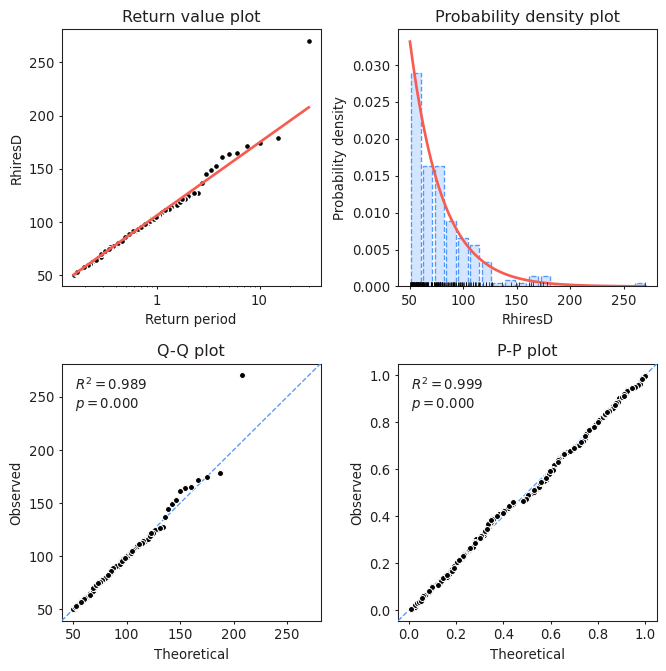

In [42]:
print("Visualising fit quality for Locarno POT GEV")
gpd_precip_bm_model.plot_diagnostic()

MODEL SUMMARY for return periods 

In [43]:
gpd_precip_bm_model_summary = gpd_precip_bm_model.get_summary(
    return_period=[10,50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [44]:
print(gpd_precip_bm_model_summary)

               return value    lower ci    upper ci
return period                                      
10.0             174.789276  159.078972  191.843830
50.0             222.900526  201.133274  246.530293
100.0            243.620914  219.245076  270.082471


GETTING ENTIRE ANNUAL RETURN PERIOD TABLE

In [45]:
return_periods_precip_bm = get_return_periods(ts=precip_series_hr_pd,
                                              extremes= gpd_precip_bm_model.extremes,
                                              extremes_method='POT', 
                                              extremes_type="high",
                                              return_period_size="365D",
                                              plotting_position="median")

In [46]:
print(return_periods_precip_bm)

              RhiresD  exceedance probability  return period
time                                                        
1981-03-30  90.686699                0.269662       0.570828
1981-04-26  58.044983                0.755931       0.203630
1981-05-25  88.449150                0.290136       0.530545
1981-06-28  61.559875                0.668915       0.230120
1981-07-23  90.763145                0.264543       0.581872
...               ...                     ...            ...
2010-05-02  75.920914                0.438577       0.350977
2010-06-16  72.615974                0.489763       0.314296
2010-08-14  57.177898                0.786643       0.195680
2010-10-31  81.859123                0.336204       0.457848
2010-11-15  74.514664                0.453932       0.339104

[195 rows x 3 columns]


                                              xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

REPEATING THE SAME EXERCISE FOR TEMPERATURE 

In [47]:
data_hr_temp=xr.open_dataset(f"{config.TARGET_DIR}/TabsD_1971_2023.nc")
data_hr_temp= data_hr_temp.sel(time=slice('1981-01-01', '2010-12-31'))

In [48]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [49]:
data_hr_temp_locarno = select_nearest_grid_cell(data_hr_temp, target_lat, target_lon, 'TabsD')

temp_series_hr = data_hr_temp_locarno['data']
lat_idx = data_hr_temp_locarno['lat_idx']
lon_idx = data_hr_temp_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TabsD' extracted
Time series shape: (10957,)
Data range: -7.54 to 29.23


In [50]:
temp_series_hr_pd= temp_series_hr.to_pandas()

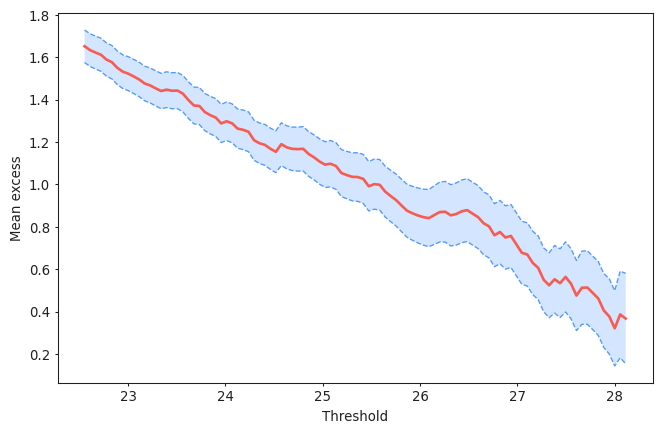

In [51]:
plot_mean_residual_life(temp_series_hr_pd)
plt.show()

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

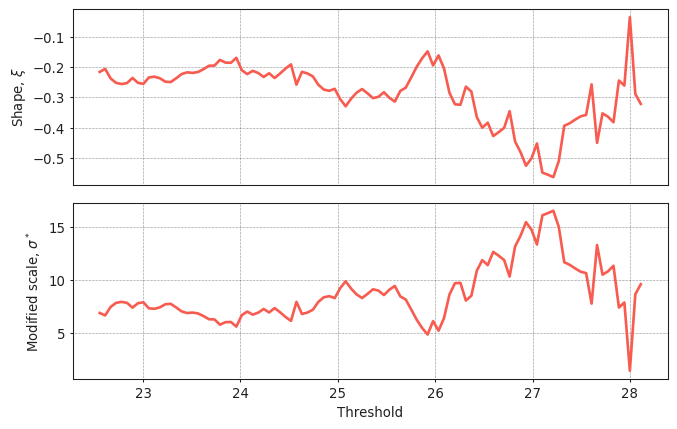

In [53]:
plot_parameter_stability(temp_series_hr_pd) #Stabilises around 25 degrees as the threshold and the higher variance with increasing threshold

#return value stability

Return value stability for 10-year return level:


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Return value stability for 50-year return level:
Return value stability for 100-year return level:


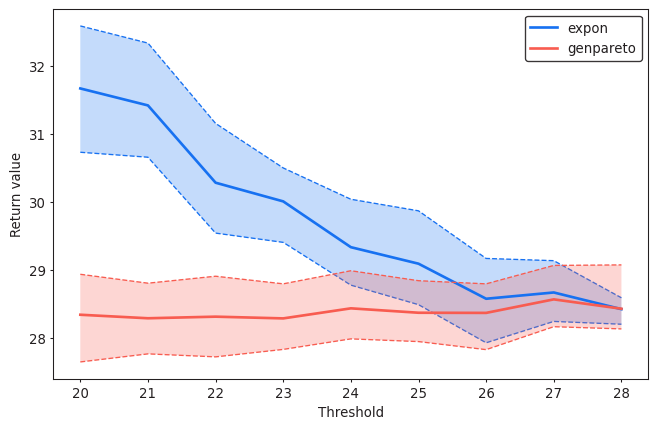

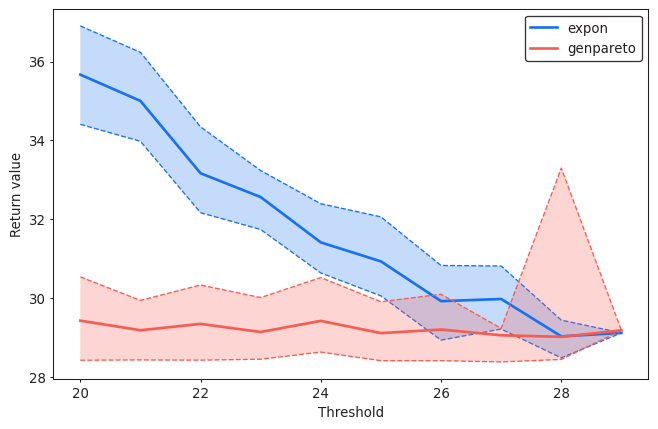

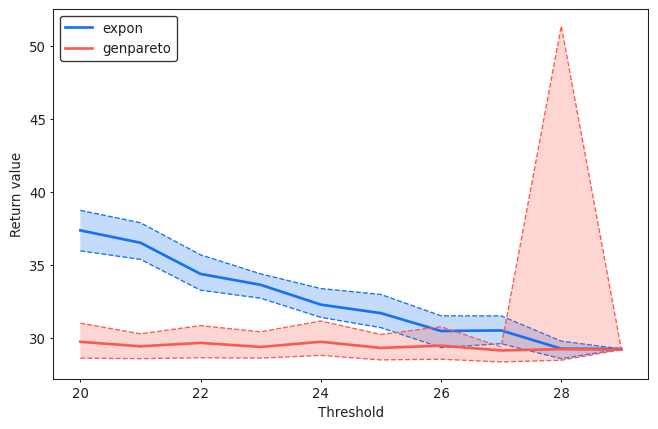

In [56]:
for i, period in enumerate([10,50,100]):
    print(f"Return value stability for {period}-year return level:")
    plot_return_value_stability(temp_series_hr_pd, 
                                return_period=period, 
                                thresholds= np.arange(20,30,1),
                                alpha=0.95,)
    

#Return value : the amount to be exceeded every 

In [57]:
from pyextremes import get_extremes, get_return_periods, EVA

In [58]:
gpd_temp_bm_model = EVA(temp_series_hr_pd)
extremes_temp= gpd_temp_bm_model.get_extremes(method="POT",
                                              threshold=25, #in degrees C
                               )

In [59]:
gpd_temp_bm_model.fit_model()
gpd_temp_bm_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                         TabsD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                106      Extraction method:                    POT
Type:                                high      Threshold:                             25
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno POT GPD


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='TabsD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='TabsD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

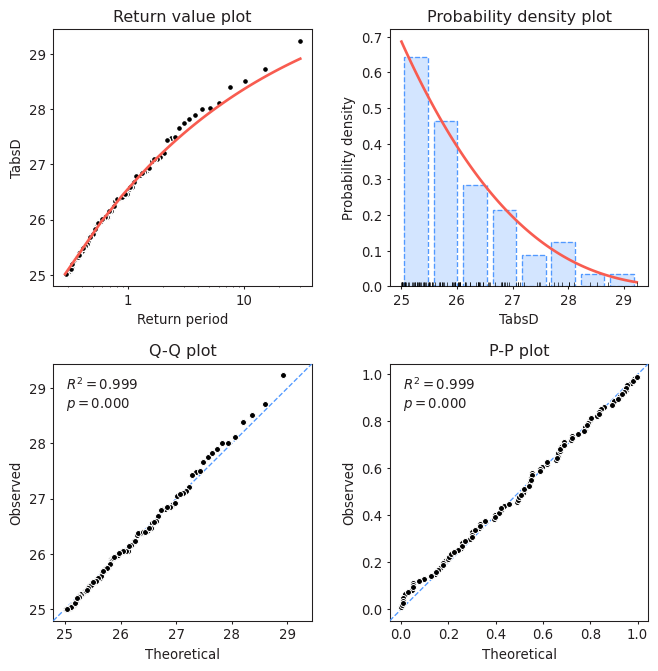

In [60]:
print("Visualising fit quality for Locarno POT GPD")
gpd_temp_bm_model.plot_diagnostic()

MODEL SUMMARY for return periods 

In [61]:
gpd_temp_bm_model_summary = gpd_temp_bm_model.get_summary(
    return_period=[10,50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [62]:
print(gpd_temp_bm_model_summary)

               return value   lower ci   upper ci
return period                                    
10.0              28.365418  27.886095  28.729514
50.0              29.112353  28.373586  29.755350
100.0             29.348490  28.485999  30.192060


In [63]:
return_periods_temp_bm = get_return_periods(ts=temp_series_hr_pd,
                                              extremes= gpd_temp_bm_model.extremes,
                                              extremes_method='POT', 
                                              extremes_type="high",
                                              return_period_size="365D",
                                              plotting_position="median")

In [64]:
print(return_periods_temp_bm)

                TabsD  exceedance probability  return period
time                                                        
1981-06-13  26.561661                0.279063       1.014732
1981-06-15  25.001617                0.993583       0.285003
1981-08-05  25.004642                0.984182       0.287725
1982-07-07  26.378954                0.344874       0.821094
1983-07-13  25.967516                0.495299       0.571723
...               ...                     ...            ...
2009-08-24  25.223873                0.843158       0.335849
2010-06-28  25.194910                0.861961       0.328523
2010-07-01  25.492132                0.692733       0.408778
2010-07-05  26.928019                0.185047       1.530283
2010-07-16  27.816792                0.081629       3.469024

[106 rows x 3 columns]
